In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Importing necessary libraries and modules
import itertools
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
# Read file from drive
eeg1 = pd.read_csv('/content/drive/MyDrive/eeg1.csv', delimiter="\t")
new_columns = eeg1.columns.values
print(new_columns)
new_columns[0] = 'time'
new_columns[33] = 'sample'
eeg1.columns = new_columns

events1 = pd.read_csv("/content/drive/MyDrive/events1.csv")

[' ' 'FP1' 'FPZ' 'FP2' 'F7' 'F3' 'FZ' 'F4' 'F8' 'FC5' 'FC1' 'FC2' 'FC6'
 'M1' 'T7' 'C3' 'CZ' 'C4' 'T8' 'M2' 'CP5' 'CP1' 'CP2' 'CP6' 'P7' 'P3' 'PZ'
 'P4' 'P8' 'POZ' 'O1' 'OZ' 'O2' 'Unnamed: 33']


In [ ]:
events1.head(100)

,number,latency,type,duration
0,1,1,0,0
1,2,66164,6,0
2,3,66760,6,0
3,4,67374,6,0
4,5,67989,6,0
...,...,...,...,...
95,96,123884,6,0
96,97,124498,6,0
97,98,125112,6,0
98,99,125727,6,0


In [ ]:
new_columns

array(['time', 'FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5',
       'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2',
       'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ',
       'O1', 'OZ', 'O2', 'sample'], dtype=object)

In [ ]:
# FInal result optimum subset of channels
j = [0, 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 15, 17, 20, 21, 23, 27, 28, 29]
for i in j:
  print(new_columns[i+1])

FP1
FPZ
FP2
F7
F3
F4
F8
FC5
FC2
FC6
T7
CZ
T8
CP1
CP2
P7
P8
POZ
O1


In [ ]:
eeg1.shape

(3469303, 34)

In [ ]:
eeg1_smol = eeg1[0:785000]
events1_smol = events1[0:1000]

In [ ]:
# Function to clean raw data
def clean_eeg(eeg, events, event_interval_length, eeg_slice_length):
    #event_list = []
    array_list = []
    index_list = []
    eeg = standardize_eeg(eeg) # function for standardizing the eeg readings

    print("1")
    # iterate over the rows of the events and slice out the corresponding eeg data
    for index, row in itertools.islice(events.iterrows(), event_interval_length): # loop through events data

        tmin, tmax = build_event_intervals(row, events)
        print("22")
        eeg_slice = cut_event_intervals(eeg, tmin, tmax)
        print("33")
        array_list, index_list = build_array(eeg_slice, eeg_slice_length,
                                             index, index_list, array_list)
    print("22")
    y_int = events.iloc[index_list] # take the event types for the correct index
    y_int = y_int['type'].values    # take just the event types as an array
    #y_int = y_int.as_matrix()            # save the event types as a matrix
    #y, lb = one_hot_events(y_int)        # one-hot the event types and save the binarizer
    X = np.stack(array_list, axis = 0)   # stack the arrays so the whole thing is 3D
    return X, y_int                     # return the data, outputs, and the binarizer


def build_event_list(row, event_list):
    # helper function to pull event types out of event data in the right order
    event_type = getattr(row, "type")
    event_list.append(event_type)

def build_event_intervals(row, events):
    # helper function to get the time intervals associated with each event
    tmin = getattr(row, "latency")
    tmin_in = getattr(row, "number")
    tmax_in = tmin_in + 1
    tmax = events1.loc[tmax_in, "latency"]
    return tmin, tmax

def cut_event_intervals(eeg, tmin, tmax):
    # helper function to slice up the eeg data so each slice is associated with one event
    eeg_slice = eeg.loc[(eeg["time"] > tmin) & (eeg["time"] < tmax)]
    eeg_slice.drop(["time", "sample"], axis = 1, inplace = True)
    return eeg_slice

def build_array(eeg_slice, eeg_slice_length, index, index_list, array_list):
    # helper function to build an array out of the eeg slices and pad them out to a standard length
    if len(eeg_slice) < eeg_slice_length:
        index_list.append(index)
        eeg_matrix = eeg_slice.values
        padded_matrix = np.pad(eeg_matrix, ((0, eeg_slice_length - len(eeg_matrix)), (0,0)),
                                   'constant', constant_values=0)
        array_list.append(padded_matrix)
    return array_list, index_list

def one_hot_events(events):
    # helper function for one-hot encoding the events
    events_list = list(events)
    lb = preprocessing.LabelBinarizer()
    lb.fit(events_list)
    events_1hot = lb.transform(events_list)
    return events_1hot, lb

def invert_one_hot(events, lb):
    # function for decoding one-hot, binarizer made in one_hot_events
    inv_events = lb.inverse_transform(events)
    return inv_events

In [ ]:
def standardize_eeg(eeg_data):
    # breaks apart an eeg dataframe, scales the eeg readings, and reassmbles it into a dataframe
    column_list = eeg_data.columns[1:33]
    time = eeg_data['time']
    sample = eeg_data['sample']
    eeg_array = eeg_data[column_list]
    eeg_stnd = scale_data(eeg_array)
    eeg_stnd_df = pd.DataFrame(eeg_stnd, index=eeg_data.index, columns=column_list)
    eeg_stnd = pd.concat([time, eeg_stnd_df, sample], axis =1)
    return eeg_stnd

def scale_data(unscaled_data):
    # helper function for standardize_eeg, fits a scaler and transforms the data
    scaler = StandardScaler()
    scaler.fit(unscaled_data)
    scaled_data = scaler.transform(unscaled_data)
    return scaled_data

In [ ]:

# define model parameters
samples = 3625  # trials of eeg data
n_features = 32  # channels of eeg in each sample
time_steps = 1300 # each sample run for
event_types = 2 #len(set(y))

In [ ]:
%%capture
# get the data into useable form and store as X and y
X, y = clean_eeg(eeg1, events1, samples, time_steps)  #4250 long, 998 short, 4330 long enhanced

In [ ]:
X.shape

(3554, 1300, 32)

In [ ]:
y.shape

(3554,)

In [ ]:

remove_list = [0,2,4,5,6]              # designate unwanted event types
drop_list = np.isin(y, remove_list)    # create a list of indices associated with unwanted events
drop_array = np.array(drop_list)

In [ ]:
y_short_int = y[np.isin(y,remove_list, invert=True)]
X_short = X[np.isin(y, remove_list, invert=True)]

In [ ]:


# one hot encode the y data without the unwanted events
y_short, lb = one_hot_events(y_short_int)



In [ ]:

import random
seed=42
random.seed(seed)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=seed)
sss.get_n_splits(X_short, y_short)

2

In [ ]:


# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X_short, y_short):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test1 = X_short[train_index], X_short[test_index]
    y_train, y_test1 = y_short[train_index], y_short[test_index]




In [ ]:
X_train.shape

(2139, 1300, 32)

In [ ]:
X_test1.shape

(917, 1300, 32)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=seed)
sss.get_n_splits(X_test1, y_test1)


# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X_test1, y_test1):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_val, X_test = X_test1[train_index], X_test1[test_index]
    y_val, y_test = y_test1[train_index], y_test1[test_index]

In [ ]:
X_train.shape

(2139, 1300, 32)

In [ ]:
X_val.shape

(458, 1300, 32)

In [ ]:
X_test.shape

(459, 1300, 32)

Differential Evolution

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

# Set up parameters for Differential Evolution
npop = 10 # Population size
F = 0.5 # Mutation factor
CR = 0.7 # Crossover rate
ngen = 100 # Number of generations

# Define fitness function
def fitness(individual, X_train, y_train, X_val, y_val):
    # Extract selected features
    selected_features = [i for i in range(len(individual)) if individual[i]==1]
    X_train_selected = X_train[:,:,selected_features]
    X_val_selected = X_val[:,:,selected_features]

    if(X_train_selected.shape[2] != 0):
      input_shape = X_train_selected.shape[1:]
      num_classes = len(np.unique(y_train))
      n_filters = 64
      kernel_size = 3
      dilation_rates = [2**i for i in range(8)]
      dropout_rate = 0.5

      inputs = Input(shape=input_shape)
      x = inputs
      for dilation_rate in dilation_rates:
          x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                    padding='causal', activation='relu')(x)
          x = Dropout(rate=dropout_rate)(x)

      x = Flatten()(x)
      x = Dense(1, activation='sigmoid')(x)
      #x = Lambda(lambda x: tf.squeeze(x, axis=1))(x)

      model = Model(inputs=inputs, outputs=x)
      #model.summary()

      optimizer = tf.keras.optimizers.Adam()
      model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
      history = model.fit(X_train_selected, y_train, batch_size=128, epochs=50, verbose = 0)
      print(selected_features)
      score = model.evaluate(X_val_selected, y_val, batch_size=128)

    return score[1]

# Initialize population randomly
pop = np.random.randint(2, size=(npop, X.shape[2]))

# Iterate through generations
for i in range(ngen):
    for j in range(npop):
        # Select three unique individuals from population
        idxs = np.random.choice(npop, 3, replace=False)
        a, b, c = pop[idxs]

        # Generate trial vector
        trial_vector = a + F * (b - c)

        # Perform crossover with probability CR
        mask = np.random.rand(X_train.shape[2]) < CR
        trial_vector[mask] = pop[j][mask]

        # Evaluate fitness of trial vector
        trial_fitness = fitness(trial_vector, X_train, y_train, X_val, y_val)
        current_fitness = fitness(pop[j], X_train, y_train, X_val, y_val)

        # Replace current individual with trial vector if fitness is better
        if trial_fitness > current_fitness:
            pop[j] = trial_vector

# Extract selected features from best individual
best_individual = pop[np.argmax([fitness(p, X_train, y_train, X_val, y_val) for p in pop])]
selected_features = [i for i in range(len(best_individual)) if best_individual[i]==1]

print("Selected features:", selected_features)


In [ ]:
[1, 3, 7, 9, 11, 13, 14, 20, 22, 23, 24, 29, 30, 31]

In [ ]:
c = [0, 1, 2, 5, 6, 8, 9, 11, 12, 13, 17, 21, 23, 24, 26, 29, 30, 31]
X_train_selected = X_train[:,:,c]
X_val_selected = X_val[:,:,c]
X_test_selected = X_test[:,:,c]

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=(time_steps, X_train_selected.shape[2])))
model.add(Dropout(0.5))
#model.add(LSTM(100)) dramatically worse results
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                    optimizer='rmsprop',
                    metrics=['accuracy'])

model.fit(X_train_selected, y_train, batch_size=32, epochs=50, validation_data = (X_val_selected, y_val))
score = model.evaluate(X_test_selected, y_test)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred = model.predict(X_test_selected)
y_pred =(y_pred>0.5)
list(y_pred)

cm = confusion_matrix(y_test, y_pred)
print(cm)

15/15 [==============================] - 1s 13ms/step
[[181   4]
 [ 21 253]]


In [ ]:
precision = cm[1][1] / ( cm[1][1] + cm[0][1])
recall = cm[1][1] / ( cm[1][1] + cm[1][0])
f1_score = (2 * precision * recall) / (precision + recall)

In [ ]:
print("Accuracy : ", score[1])
print("Precision : ", precision)
print("Recall : ", recall)
print("F1 Score: ", f1_score)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Dense, Lambda, Flatten
from tensorflow.keras.models import Model

In [ ]:
    input_shape = X_train_selected.shape[1:]
    num_classes = len(np.unique(y_train))
    n_filters = 64
    kernel_size = 3
    dilation_rates = [2**i for i in range(8)]
    dropout_rate = 0.5

    inputs = Input(shape=input_shape)
    x = inputs
    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                  padding='causal', activation='relu')(x)
        x = Dropout(rate=dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    #x = Lambda(lambda x: tf.squeeze(x, axis=1))(x)

    model = Model(inputs=inputs, outputs=x)
    #model.summary()

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train_selected, y_train, batch_size=128, epochs=75, validation_data=(X_val_selected, y_val)
    , callbacks = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        mode = 'auto',
        baseline = None,
        restore_best_weights=True,
        start_from_epoch = 15
    ))

    score = model.evaluate(X_test_selected, y_test, batch_size=128)

Epoch 1/75
17/17 [==============================] - 7s 183ms/step - loss: 1.4338 - accuracy: 0.5138 - val_loss: 0.6926 - val_accuracy: 0.5983
Epoch 2/75
17/17 [==============================] - 2s 110ms/step - loss: 0.6751 - accuracy: 0.5979 - val_loss: 0.6900 - val_accuracy: 0.5983
Epoch 3/75
17/17 [==============================] - 2s 109ms/step - loss: 0.6735 - accuracy: 0.5979 - val_loss: 0.6843 - val_accuracy: 0.5983
Epoch 4/75
17/17 [==============================] - 2s 109ms/step - loss: 0.6725 - accuracy: 0.5979 - val_loss: 0.6865 - val_accuracy: 0.5983
Epoch 5/75
17/17 [==============================] - 2s 109ms/step - loss: 0.6725 - accuracy: 0.5979 - val_loss: 0.6860 - val_accuracy: 0.5983
Epoch 6/75
17/17 [==============================] - 2s 109ms/step - loss: 0.6718 - accuracy: 0.5979 - val_loss: 0.6854 - val_accuracy: 0.5983
Epoch 7/75
17/17 [==============================] - 2s 111ms/step - loss: 0.6720 - accuracy: 0.5979 - val_loss: 0.6860 - val_accuracy: 0.5983
Epoch 

In [ ]:
y_pred_proba = model.predict(X_test_selected)

15/15 [==============================] - 2s 22ms/step


In [ ]:
fpr_evol, tpr_evol, _evol = metrics.roc_curve(y_test,  y_pred_proba)

In [ ]:
fpr_tlbo,tpr_tlbo,_ = metrics.roc_curve(y_test,  y_pred_proba)

In [ ]:
y_pred_proba.shape

(459, 1)

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

In [ ]:
0.1 = 0.7860865020751954
0.2 = 0.7958531665802002
0.3 = 0.7867898225784302
0.4 = 0.8044837808609009
0.5 = 0.782066960334778
#0.6 to 1.0
0.6 = 0.7748844146728515
0.7 = 0.7774926662445069
0.8 = 0.8079028511047364
0.9 = 0.8221027183532714, 0.8026619291305543, .8019454669952394
1.0 = 0.8103472948074341

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
# 0.1 = 0.7860865020751954
# 0.2 = 0.7958531665802002
# 0.3 = 0.7967898225784302
# 0.4 = 0.8044837808609009
# 0.5 = 0.782066960334778
# #0.6 to 1.0
# 0.6 = 0.7748844146728515
# 0.7 = 0.7774926662445069
# 0.8 = 0.8079028511047364
# 0.9 = 0.8221027183532714, 0.8026619291305543, .8019454669952394
# 1.0 = 0.8103472948074341

In [ ]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y = [0.7960865020751954,  0.8058531665802002, 0.7997898225784302,  0.8144837808609009, 0.808066960334778, 0.8078844146728515, 0.8074926662445069, 0.8209028511047364, 0.8271027183532714, 0.8103472948074341]

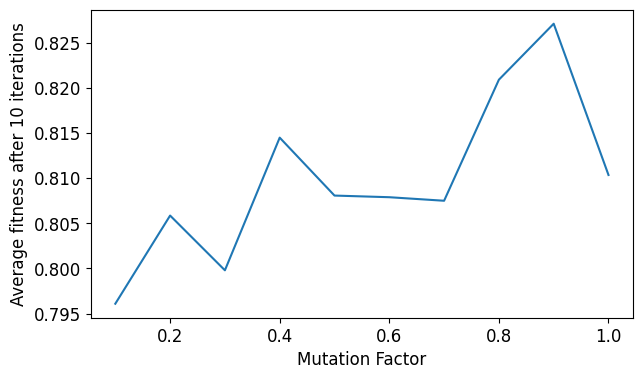

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(x,y)
plt.ylabel('Average fitness after 10 iterations', fontsize = '12')
plt.xlabel('Mutation Factor', fontsize = '12')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

TLBO

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Dense, Lambda, Flatten
from tensorflow.keras.models import Model

In [ ]:
def generateInitialPopulation(X, pop_size):
  population = []
  length = X.shape[2]
  for i in range(pop_size):
    temp = []
    for j in range(length):
      temp.append(np.random.randint(2))
    population.append(temp)
  return np.array(population)

In [ ]:
def calcAccuracy(X_train, Y_train, instance):
  X_train_selected = X_train[:, :, instance == 1]
  X_val_selected = X_val[:, :, instance == 1]

  if(X_train_selected.shape[2] != 0):
    input_shape = X_train_selected.shape[1:]
    num_classes = len(np.unique(y_train))
    n_filters = 64
    kernel_size = 3
    dilation_rates = [2**i for i in range(8)]
    dropout_rate = 0.5

    inputs = Input(shape=input_shape)
    x = inputs
    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                  padding='causal', activation='relu')(x)
        x = Dropout(rate=dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    #x = Lambda(lambda x: tf.squeeze(x, axis=1))(x)

    model = Model(inputs=inputs, outputs=x)
    #model.summary()

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train_selected, y_train, batch_size=128, epochs=50, verbose = 0)


    score = model.evaluate(X_val_selected, y_val,batch_size=128, verbose = 0)
    fitness = ( 0.2 * (1 - (X_train_selected.shape[2] / X_train.shape[2])) )  + ( 0.8 * score[1] )
    return fitness
  return 0

In [ ]:
def TLBO(pop_size, iterations, X, Y):
  population = generateInitialPopulation(X, pop_size)
  #columns = X.columns
  fitness_values = []
  for i in range(iterations):
    mean_values = np.mean(population, axis = 0)

    fitness_values = []
    for j in range(pop_size):
      fitness_values.append(calcAccuracy(X, Y, population[j]))
      print(population[j], fitness_values[-1])
    fitness_values = np.array(fitness_values)

    ## Teaching Phase
    teacher_index = np.argmax(fitness_values)
    #print("Teacher is at index ", teacher_index)
    print("Iteration", i+1, "Best Fitness", fitness_values[teacher_index])

    teaching_factor = float(np.random.randint(2))+1
    r = np.random.random(X.shape[1])
    diff_mean = r * (population[teacher_index] - (teaching_factor*mean_values))

    # Updating each learner in the population

    temp_population = []
    for j in range(pop_size):
      temp_population = population[j] + diff_mean
      for k in range(X.shape[1]):
        if(temp_population[k] < 0.5):
          temp_population[k] = 0
        else:
          temp_population[k] = 1
      if( fitness_values[j] < calcAccuracy(X, Y, temp_population, columns)):
        population[j] = temp_population

    ## Learning Phase
    learner1 = np.random.randint(pop_size)
    learner2 = np.random.randint(pop_size)

    while(learner1 == learner2):
      learner2 = np.random.randint(pop_size)

    if(fitness_values[learner1] > fitness_values[learner2]):
      temp_population = population[learner1] + r * (population[learner1] - population[learner2])
    else:
      temp_population = population[learner1] + r * (population[learner2] - population[learner1])


    for k in range(X.shape[1]):
      if(temp_population[k] < 0.5):
        temp_population[k] = 0
      else:
        temp_population[k] = 1

    if( fitness_values[learner1] < calcAccuracy(X, Y, temp_population)):
      population[learner1] = temp_population

  optimum_selection_index = np.argmax(fitness_values)
  print("Best fitness is ", fitness_values[optimum_selection_index])

  return population[optimum_selection_index]

In [ ]:
pop_size = 10
iterations = 2
optimum_pop = TLBO(pop_size, iterations, X_train, y_train)
print(optimum_pop)

[1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1] 0.5875272750854492
[0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0] 0.8832696437835694
[0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1] 0.6666757583618165
[0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1] 0.6120633125305176
[0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0] 0.44189410209655766
[1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0] 0.697843885421753
[0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1] 0.5504639625549317
[1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0] 0.6340338230133057
[1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1] 0.46479258537292484
[0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1] 0.8473253250122071
Iteration 1 Best Fitness 0.8832696437835694


ValueError: ignored

In [ ]:
c = [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
X_train_selected = X_train[:, :, np.nonzero(c)[0]]
X_val_selected = X_val[:, :, np.nonzero(c)[0]]
X_test_selected = X_test[:, :, np.nonzero(c)[0]]

In [ ]:
X_train_selected.shape

(2139, 1300, 17)

In [ ]:
del model

In [ ]:
    input_shape = X_train_selected.shape[1:]
    num_classes = len(np.unique(y_train))
    n_filters = 64
    kernel_size = 3
    dilation_rates = [2**i for i in range(8)]
    dropout_rate = 0.5

    inputs = Input(shape=input_shape)
    x = inputs
    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                  padding='causal', activation='relu')(x)
        x = Dropout(rate=dropout_rate)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    #x = Lambda(lambda x: tf.squeeze(x, axis=1))(x)

    model = Model(inputs=inputs, outputs=x)
    #model.summary()

    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train_selected, y_train, batch_size=128, epochs=40,validation_data=(X_val_selected, y_val), callbacks = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        mode = 'auto',
        baseline = None,
        restore_best_weights=True,
        start_from_epoch = 15
    ))


    score = model.evaluate(X_test_selected, y_test, batch_size=128)

    print(score)

Epoch 1/40
17/17 [==============================] - 7s 199ms/step - loss: 0.9951 - accuracy: 0.5283 - val_loss: 0.6926 - val_accuracy: 0.5983
Epoch 2/40
17/17 [==============================] - 2s 115ms/step - loss: 0.6767 - accuracy: 0.5979 - val_loss: 0.6829 - val_accuracy: 0.5983
Epoch 3/40
17/17 [==============================] - 2s 107ms/step - loss: 0.6717 - accuracy: 0.5979 - val_loss: 0.6811 - val_accuracy: 0.5983
Epoch 4/40
17/17 [==============================] - 2s 107ms/step - loss: 0.6723 - accuracy: 0.5979 - val_loss: 0.6837 - val_accuracy: 0.5983
Epoch 5/40
17/17 [==============================] - 2s 111ms/step - loss: 0.6709 - accuracy: 0.5979 - val_loss: 0.6869 - val_accuracy: 0.5983
Epoch 6/40
17/17 [==============================] - 2s 108ms/step - loss: 0.6705 - accuracy: 0.5979 - val_loss: 0.6885 - val_accuracy: 0.5983
Epoch 7/40
17/17 [==============================] - 2s 108ms/step - loss: 0.6695 - accuracy: 0.5979 - val_loss: 0.6913 - val_accuracy: 0.5983
Epoch 

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred = model.predict(X_test_selected)
y_pred =(y_pred>0.5)
list(y_pred)

cm = confusion_matrix(y_test, y_pred)
print(cm)

15/15 [==============================] - 1s 26ms/step
[[148  37]
 [ 88 186]]


In [ ]:
precision = cm[1][1] / ( cm[1][1] + cm[0][1])
recall = cm[1][1] / ( cm[1][1] + cm[1][0])
f1_score = (2 * precision * recall) / (precision + recall)

In [ ]:
print("Accuracy : ", score[1])
print("Precision : ", precision)
print("Recall : ", recall)
print("F1 Score: ", f1_score)

Accuracy :  0.9324618577957153
Precision :  0.9919028340080972
Recall :  0.8941605839416058
F1 Score:  0.9404990403071019


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

In [ ]:

model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=(time_steps, X_train_selected.shape[2])))
model.add(Dropout(0.5))
#model.add(LSTM(100)) dramatically worse results
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit the model
model.fit(X_train_selected, y_train, batch_size=32, epochs=50, validation_data = (X_val_selected, y_val))

# evaluate the model
score = model.evaluate(X_test_selected, y_test)
print(score[1])

Epoch 1/50
67/67 [==============================] - 6s 64ms/step - loss: 0.6775 - accuracy: 0.5970 - val_loss: 0.6753 - val_accuracy: 0.5983
Epoch 2/50
67/67 [==============================] - 3s 48ms/step - loss: 0.6750 - accuracy: 0.5979 - val_loss: 0.6741 - val_accuracy: 0.5983
Epoch 3/50
67/67 [==============================] - 3s 46ms/step - loss: 0.6759 - accuracy: 0.5979 - val_loss: 0.6746 - val_accuracy: 0.5983
Epoch 4/50
67/67 [==============================] - 3s 45ms/step - loss: 0.6755 - accuracy: 0.5975 - val_loss: 0.6757 - val_accuracy: 0.5983
Epoch 5/50
67/67 [==============================] - 3s 52ms/step - loss: 0.6732 - accuracy: 0.5979 - val_loss: 0.6989 - val_accuracy: 0.5153
Epoch 6/50
67/67 [==============================] - 3s 50ms/step - loss: 0.6746 - accuracy: 0.5975 - val_loss: 0.6792 - val_accuracy: 0.5983
Epoch 7/50
67/67 [==============================] - 3s 46ms/step - loss: 0.6726 - accuracy: 0.5965 - val_loss: 0.6772 - val_accuracy: 0.5983
Epoch 8/50
67

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred = model.predict(X_test_selected)
y_pred =(y_pred>0.5)
list(y_pred)

cm = confusion_matrix(y_test, y_pred)
print(cm)

15/15 [==============================] - 1s 24ms/step
[[151  34]
 [107 167]]


In [ ]:
precision = cm[1][1] / ( cm[1][1] + cm[0][1])
recall = cm[1][1] / ( cm[1][1] + cm[1][0])
f1_score = (2 * precision * recall) / (precision + recall)

In [ ]:
print("Accuracy : ", score[1])
print("Precision : ", precision)
print("Recall : ", recall)
print("F1 Score: ", f1_score)

Accuracy :  0.6928104758262634
Precision :  0.8308457711442786
Recall :  0.6094890510948905
F1 Score:  0.7031578947368421


In [ ]:
# code for building an LSTM with 100 neurons and dropout. Runs for 50 epochs

model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.5))
#model.add(LSTM(100)) dramatically worse results
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data = (X_val, y_val))


In [ ]:
score = model.evaluate(X_test, y_test, batch_size=32)

15/15 [==============================] - 1s 96ms/step - loss: 0.8890 - accuracy: 0.7168


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))
print(f1_score(y_test, y_pred , average="macro"))

In [ ]:
print("Testing Accuracy : ", score[1]*100)

Testing Accuracy :  71.67755961418152


In [ ]:
print(score)

[0.6600409746170044, 0.7124183177947998]


In [ ]:
population_size = 10
num_features = X_train.shape[2]
population = np.random.rand(population_size, num_features)
best_solution, best_fitness = tlbo(population, fitness_function, max_iterations=5, de_factor=0.5, de_weight=0.8)

In [ ]:
best_fitness

In [ ]:
X_ss = X_train[: , :, best_solution == 1]

In [ ]:
X_ss.shape

In [ ]:
best_solution

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True, input_shape = (1,100))) #amatically worse results
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=16, epochs=50)
score = model.evaluate(X_test, y_test, batch_size=16)

In [ ]:
print(score)

In [ ]:
import pandas as pd
import seaborn as sb

TLBO+DE

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

In [ ]:
def objective_function1(x):

    # Select features
    selected_features = np.nonzero(x)[0]
    X_train_selected = X_train[:,:,selected_features]
    X_val_selected = X_val[:,:, selected_features]


    model = Sequential()
    model.add(LSTM(100,
                   return_sequences=False,
                   input_shape =(time_steps, X_train_selected.shape[2])
                   ))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(X_train_selected, y_train, batch_size=32, epochs=50, verbose = 0, validation_data=(X_val_selected, y_val), callbacks = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode = 'auto',
        baseline = None,
        restore_best_weights=True,
        start_from_epoch = 20
    ))
    score = model.evaluate(X_val_selected, y_val, batch_size=32)

    #Multi objective fitness function
    fitness = ( 0.2 * (1 - (X_train_selected.shape[2] / X_train.shape[2])) )  + ( 0.8 * score[1] )


    print(selected_features, score, fitness)
    del X_train_selected, X_val_selected
    return fitness

In [ ]:
def tlbo_de_feature_selection1(objective_function, bounds, pop_size=10, max_iter=2 , F=1.0):
    # Initialize population
    pop = np.random.randint(0, 2, size=(pop_size, bounds.shape[0]))

    # Evaluate population fitness
    fitness = np.apply_along_axis(objective_function, 1, pop)
    print("Initial mean fitness:", np.mean(fitness))
    for i in range(max_iter):
        print("iteration ", i)
        # Calculate mean of population
        mean = np.mean(pop, axis=0)

        # Create new individuals using DE
        idx = np.random.permutation(pop_size)
        #a, b, c = pop[idx[:3]]
        #mutant = a + F * (b - c)
        a, b, d, e = pop[idx[:4]]
        mutant = a + F * (mean - b) + F * (d - e)
        trial = np.clip(mutant, 0, 1)

        # Evaluate trial solution
        trial_fitness = objective_function(trial)

        # Replace worst individual in population with trial solution if it is better
        worst_idx = np.argmin(fitness)
        if trial_fitness > fitness[worst_idx]:
            pop[worst_idx] = trial
            fitness[worst_idx] = trial_fitness

        # Calculate mean of population again after replacement
        mean = np.mean(pop, axis=0)

        # Perform TLBO operation on population
        for j in range(pop_size):
            # Find best and second best individuals in population except for the current one
            idx = np.delete(np.arange(pop_size), j)
            sorted_idx = np.argsort(fitness[idx])[::-1]
            best = pop[idx[sorted_idx[0]]]
            second_best = pop[idx[sorted_idx[1]]]

            # Calculate difference vector between current individual and mean
            diff = mean - pop[j]

            # Perform teaching phase
            new_individual = pop[j] + np.random.uniform() * (best - F * diff)

            # Perform learning phase
            new_individual += np.random.uniform() * (second_best - F * diff)

            # Clip values to ensure they are within bounds
            new_individual = np.clip(new_individual, 0, 1)
            new_fitness = objective_function(new_individual)
            # Update fitness of current individual
            if(new_fitness > fitness[j]):
              fitness[j] = new_fitness
              pop[j] = new_individual
        print("Mean fitness:", np.mean(fitness))
    # Return best solution found
    best_idx = np.argmax(fitness)
    return pop[best_idx], fitness[best_idx]

bounds = np.ones(X_train.shape[2])
x, f = tlbo_de_feature_selection1(objective_function1, bounds)
selected_features = np.nonzero(x)[0]
print(selected_features)

15/15 [==============================] - 0s 27ms/step - loss: 0.7049 - accuracy: 0.5721
[ 2  4 12 15 16 17 20 21 22 23 25 26 27 28 29] [0.7049228549003601, 0.5720524191856384] 0.5638919353485108
15/15 [==============================] - 0s 28ms/step - loss: 0.7197 - accuracy: 0.6245
[ 0  4  8  9 13 14 15 17 19 20 21 23] [0.719723641872406, 0.624454140663147] 0.6245633125305177
15/15 [==============================] - 0s 18ms/step - loss: 0.4959 - accuracy: 0.8013
[ 2  3  6  7  8 10 11 13 16 17 19 20 24 25 27 28] [0.49587371945381165, 0.8013100624084473] 0.7410480499267579
15/15 [==============================] - 0s 30ms/step - loss: 0.6802 - accuracy: 0.6485
[ 4  5  6  7  9 11 13 18 20 23 24 25 27 28 29] [0.6802165508270264, 0.6484715938568115] 0.6250272750854493
15/15 [==============================] - 0s 27ms/step - loss: 0.8053 - accuracy: 0.5328
[ 2  3  4  6  9 13 17 18 20 21 22 24 26 27 28 29 31] [0.8053080439567566, 0.5327510833740234] 0.5199508666992188
15/15 [===================

KeyboardInterrupt: ignored

Classification

In [ ]:
selected_features = [  0 ,3,  4 , 5,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 22, 25, 27, 29]
X_train_selected = X_train[:,:,selected_features]
X_val_selected = X_val[:,:, selected_features]
X_test_selected = X_test[:,:,selected_features]

In [ ]:
    input_shape = X_train_selected.shape[1:]
    num_classes = len(np.unique(y_train))
    n_filters = 64
    kernel_size = 3
    dilation_rates = [2**i for i in range(8)]
    dropout_rate = 0.5

    inputs = Input(shape=input_shape)
    x = inputs
    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                  padding='causal', activation='relu')(x)
        x = Dropout(rate=dropout_rate)(x)

    x = Dense(1, activation='sigmoid')(x)

    model1 = Model(inputs=inputs, outputs=x)
    optimizer = tf.keras.optimizers.Adam()
    model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model1.fit(X_train_selected, y_train, batch_size=128, epochs=100, validation_data=(X_val_selected, y_val), verbose = 1, callbacks = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        mode = 'auto',
        baseline = None,
        restore_best_weights=True,
        start_from_epoch = 15
    ))
    score = model1.evaluate(X_test_selected, y_test,batch_size=128, verbose = 0)
    print(score[1])

Epoch 1/100
17/17 [==============================] - 7s 142ms/step - loss: 0.6893 - accuracy: 0.5738 - val_loss: 0.6830 - val_accuracy: 0.5983
Epoch 2/100
17/17 [==============================] - 2s 110ms/step - loss: 0.6789 - accuracy: 0.5979 - val_loss: 0.6828 - val_accuracy: 0.5983
Epoch 3/100
17/17 [==============================] - 2s 111ms/step - loss: 0.6751 - accuracy: 0.5979 - val_loss: 0.6778 - val_accuracy: 0.5983
Epoch 4/100
17/17 [==============================] - 2s 110ms/step - loss: 0.6728 - accuracy: 0.5979 - val_loss: 0.6777 - val_accuracy: 0.5983
Epoch 5/100
17/17 [==============================] - 2s 111ms/step - loss: 0.6685 - accuracy: 0.5979 - val_loss: 0.6778 - val_accuracy: 0.5983
Epoch 6/100
17/17 [==============================] - 2s 113ms/step - loss: 0.6571 - accuracy: 0.5979 - val_loss: 0.6748 - val_accuracy: 0.5983
Epoch 7/100
17/17 [==============================] - 2s 116ms/step - loss: 0.6403 - accuracy: 0.5979 - val_loss: 0.6609 - val_accuracy: 0.5983

In [ ]:
0.1 = 0.7860865020751954
0.2 = 0.7958531665802002
0.3 = 0.7867898225784302
0.4 = 0.8044837808609009
0.5 = 0.782066960334778
#0.6 to 1.0
0.6 = 0.7748844146728515
0.7 = 0.7774926662445069
0.8 = 0.8079028511047364
0.9 = 0.8221027183532714, 0.8026619291305543, .8019454669952394
1.0 = 0.8103472948074341

SyntaxError: ignored

In [ ]:
print(f)

0.8353268146514893


In [ ]:
# [ 0  1  2  3  4  6  7  8 10 11 13 15 17 20 21 23 27 28 29] gives 93.4 accuracy
# [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 24 25 27 28 29 30] 0.9496

In [ ]:
selected_features = [ 0 ,3,  4 , 5,  6,  7,  8, 12, 13, 14, 15, 16, 17, 18, 19, 22, 25, 27, 29]
X_train_selected = X_train[:,:,selected_features]
X_val_selected = X_val[:,:, selected_features]
X_test_selected = X_test[:,:,selected_features]

In [ ]:

selected_features = [ 0, 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 15, 17, 20, 21, 23, 27, 28, 29]
X_train_selected = X_train[:,:,selected_features]
X_val_selected = X_val[:,:, selected_features]
X_test_selected = X_test[:,:,selected_features]

In [ ]:
selected_features = [ 0 ,2,  3,  4,  8, 11, 13, 16, 17, 19, 21, 22, 24, 26, 29, 31]
X_train_selected = X_train[:,:,selected_features]
X_val_selected = X_val[:,:, selected_features]
X_test_selected = X_test[:,:,selected_features]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Dense, Lambda, Flatten
from tensorflow.keras.models import Model

In [ ]:
input_shape = X_train_selected.shape[1:]
num_classes = len(np.unique(y_train))
n_filters = 64
kernel_size = 3
dilation_rates = [2**i for i in range(8)]
dropout_rate = 0.5

inputs = Input(shape=input_shape)
x = inputs
for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
               padding='causal', activation='relu')(x)
    x = Dropout(rate=dropout_rate)(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)
#x = Lambda(lambda x: tf.squeeze(x, axis=1))(x)

model = Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 1300, 16)]        0         
                                                                 
 conv1d_256 (Conv1D)         (None, 1300, 64)          3136      
                                                                 
 dropout_256 (Dropout)       (None, 1300, 64)          0         
                                                                 
 conv1d_257 (Conv1D)         (None, 1300, 64)          12352     
                                                                 
 dropout_257 (Dropout)       (None, 1300, 64)          0         
                                                                 
 conv1d_258 (Conv1D)         (None, 1300, 64)          12352     
                                                                 
 dropout_258 (Dropout)       (None, 1300, 64)          0  

In [ ]:
0.9611#all features
0.9496#w 24 feture
0.9497 # w 19

0.9434

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train_selected, y_train, batch_size=128, epochs=150, validation_data=(X_val_selected, y_val), callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode = 'auto',
    baseline = None,
    restore_best_weights=True,
    start_from_epoch = 15
))
score = model.evaluate(X_test_selected, y_test,batch_size=128 )

Epoch 1/150
17/17 [==============================] - 7s 136ms/step - loss: 0.9234 - accuracy: 0.5273 - val_loss: 0.6928 - val_accuracy: 0.5983
Epoch 2/150
17/17 [==============================] - 2s 110ms/step - loss: 0.6779 - accuracy: 0.5979 - val_loss: 0.6926 - val_accuracy: 0.5983
Epoch 3/150
17/17 [==============================] - 2s 110ms/step - loss: 0.6734 - accuracy: 0.5979 - val_loss: 0.6886 - val_accuracy: 0.5983
Epoch 4/150
17/17 [==============================] - 2s 111ms/step - loss: 0.6740 - accuracy: 0.5979 - val_loss: 0.6905 - val_accuracy: 0.5983
Epoch 5/150
17/17 [==============================] - 2s 114ms/step - loss: 0.6726 - accuracy: 0.5979 - val_loss: 0.6904 - val_accuracy: 0.5983
Epoch 6/150
17/17 [==============================] - 2s 115ms/step - loss: 0.6709 - accuracy: 0.5979 - val_loss: 0.6908 - val_accuracy: 0.5983
Epoch 7/150
17/17 [==============================] - 2s 113ms/step - loss: 0.6700 - accuracy: 0.5979 - val_loss: 0.6908 - val_accuracy: 0.5983

In [ ]:
del model

In [ ]:
print(model.predict(X_test).shape)

15/15 [==============================] - 1s 14ms/step
(459, 1)


In [ ]:
y_pred = model.predict(X_test)
y_pred =(y_pred>0.5)
list(y_pred)

cm = confusion_matrix(y_test, y_pred)
print(cm)

15/15 [==============================] - 0s 13ms/step
[[179   6]
 [ 25 249]]


In [ ]:
cm[1][0]

16

In [ ]:
precision = cm[1][1] / ( cm[1][1] + cm[0][1])
recall = cm[1][1] / ( cm[1][1] + cm[1][0])
f1_score = (2 * precision * recall) / (precision + recall)

In [ ]:
print("Accuracy : " , score[1])
print("Precision : ", precision)
print("Recall : ", recall)
print("F1 Score : ", f1_score)

Accuracy :  0.9324618577957153
Precision :  0.9764705882352941
Recall :  0.9087591240875912
F1 Score :  0.9413988657844989


In [ ]:
y_pred

array([[[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]])

In [ ]:
print("Accuracy : ", accuracy)
print("Precision : ", precision)
print("Recall : ", recall)
print("F1 Score: ", f1_score)

In [ ]:
input_shape = X_train_selected.shape[1:]
num_classes = len(np.unique(y_train))
n_filters = 64
kernel_size = 3
dilation_rates = [2**i for i in range(8)]
dropout_rate = 0.5

inputs = Input(shape=input_shape)
x = inputs
for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
               padding='causal', activation='relu')(x)
    x = Dropout(rate=dropout_rate)(x)

x = Dense(1, activation='sigmoid')(x)
#x = Lambda(lambda x: tf.squeeze(x, axis=1))(x)

model1 = Model(inputs=inputs, outputs=x)
model1.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1300, 19)]        0         
                                                                 
 conv1d_72 (Conv1D)          (None, 1300, 64)          3712      
                                                                 
 dropout_72 (Dropout)        (None, 1300, 64)          0         
                                                                 
 conv1d_73 (Conv1D)          (None, 1300, 64)          12352     
                                                                 
 dropout_73 (Dropout)        (None, 1300, 64)          0         
                                                                 
 conv1d_74 (Conv1D)          (None, 1300, 64)          12352     
                                                                 
 dropout_74 (Dropout)        (None, 1300, 64)          0   

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model1.fit(X_train_selected, y_train, batch_size=128, epochs=150, validation_data=(X_val_selected, y_val), callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode = 'auto',
    baseline = None,
    restore_best_weights=True,
    start_from_epoch = 15
))
score = model1.evaluate(X_test_selected, y_test,batch_size=128 )

Epoch 1/150
17/17 [==============================] - 6s 159ms/step - loss: 0.1937 - accuracy: 0.9248 - val_loss: 0.1443 - val_accuracy: 0.9478
Epoch 2/150
17/17 [==============================] - 2s 114ms/step - loss: 0.1600 - accuracy: 0.9384 - val_loss: 0.1775 - val_accuracy: 0.9331
Epoch 3/150
17/17 [==============================] - 2s 111ms/step - loss: 0.1628 - accuracy: 0.9375 - val_loss: 0.1461 - val_accuracy: 0.9465
Epoch 4/150
17/17 [==============================] - 2s 110ms/step - loss: 0.1599 - accuracy: 0.9376 - val_loss: 0.1869 - val_accuracy: 0.9299
Epoch 5/150
17/17 [==============================] - 2s 109ms/step - loss: 0.1542 - accuracy: 0.9413 - val_loss: 0.1770 - val_accuracy: 0.9330
Epoch 6/150
17/17 [==============================] - 2s 111ms/step - loss: 0.1530 - accuracy: 0.9416 - val_loss: 0.1854 - val_accuracy: 0.9307
Epoch 7/150
17/17 [==============================] - 2s 112ms/step - loss: 0.1565 - accuracy: 0.9405 - val_loss: 0.1718 - val_accuracy: 0.9356

In [ ]:

    model = Sequential()
    model.add(LSTM(100,
                   return_sequences=False,
                   input_shape =(time_steps, X_train_selected.shape[2])
                   ))
    model.add(Dropout(0.5))
    #model.add(LSTM(100, return_sequences=True, input_shape = (1,100))) #amatically worse results
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    model.fit(X_train_selected, y_train, batch_size=32, epochs=50, verbose = 1)
    score = model.evaluate(X_val_selected, y_val, batch_size=32)
    score = model.evaluate(X_test_selected, y_test, batch_size=32)

In [ ]:
fitness = []
pop = []

In [ ]:
 0  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 22 25 27 28 29 30 31

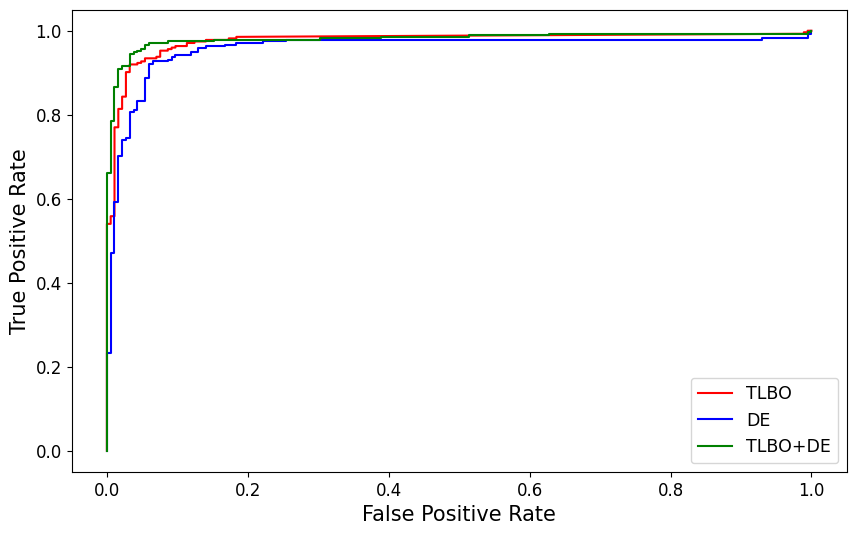

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(fpr_tlbo,tpr_tlbo, color = 'red', label = 'TLBO', linewidth = '1.5')
plt.plot(fpr_evol,tpr_evol, color = 'blue', label = 'DE', linewidth = '1.5')
plt.plot(fpr,tpr, color = 'green', label = 'TLBO+DE', linewidth = '1.5')
plt.ylabel('True Positive Rate', fontsize = '15', fontweight = 'medium')
plt.xlabel('False Positive Rate', fontsize = '15', fontweight = 'medium')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc = 'best', fontsize = '12.5')
plt.show()